<a href="https://colab.research.google.com/github/lucabarattini/Trees-Boosting-AppliedML-Project/blob/main/Luca_Barattini_%7C_LB3656_%7C_Applied_Machine_Learning_Assignment_2_%7C_Trees_and_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMSW4995 - Applied Machine Learning


---


### Luca Barattini - @lb3656:


---


### Project description and goal:
The goal of the project is to explore the intricate power of Boosting methods. We will move beyond the implementation of a single model and investigate how Boosting approaches can improve generalization by correcting residual errors in sequential learners.


---


### Dataset description and problem scoping:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


---


### Now, let's start by importing our libraries:





In [1]:
# ===== Core =====
import math
import numpy as np
import pandas as pd

# ===== Plotting (matplotlib only) =====
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ===== Scikit-learn: models, tuning, metrics =====
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report, log_loss
)
from pathlib import Path
from collections import defaultdict


# ===== XGBoost =====
import xgboost as xgb

# pandas display opts
pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv('bank-additional-full.csv', delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Let's explore the data types and possible null values:

In [3]:
df.info()
print('*'*150)
print(df.isnull().sum())
print('*'*150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### No null values with the typical NaN representation but many cateogorical values, let's proceed with a deep-dive on them:

In [4]:
print('Unique values by column:')
print('job         →', df['job'].unique())
print('marital     →', df['marital'].unique())
print('education   →', df['education'].unique())
print('default     →', df['default'].unique())
print('housing     →', df['housing'].unique())
print('loan        →', df['loan'].unique())
print('contact     →', df['contact'].unique())
print('month       →', df['month'].unique())
print('day_of_week →', df['day_of_week'].unique())
print('poutcome    →', df['poutcome'].unique())
print('y           →', df['y'].unique())


Unique values by column:
job         → ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital     → ['married' 'single' 'divorced' 'unknown']
education   → ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default     → ['no' 'unknown' 'yes']
housing     → ['no' 'yes' 'unknown']
loan        → ['no' 'yes' 'unknown']
contact     → ['telephone' 'cellular']
month       → ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week → ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome    → ['nonexistent' 'failure' 'success']
y           → ['no' 'yes']


### From this code we have seen that our target variable y is categorical (i.e. 'yes' or 'no'). Let's adress this issue immediately and convert into a numerical signal:

In [5]:
df['y'] = (df['y'] == 'yes').astype('int8')  # yes→1, no→0

### Now, let's dive deeper into an EDA for our dataset:

In [6]:
def ensure_cols(df, cols):
    return [c for c in cols if c in df.columns]

b_dark, b_mid, b_light = "#2C7FB8", "#6BAED6", "#BBD7EA"

In [7]:
display(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


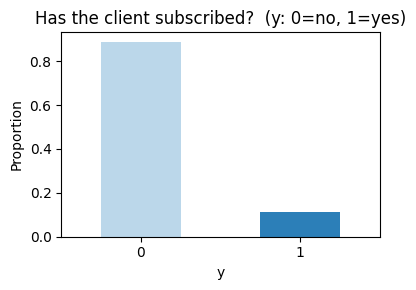

In [8]:
# =========================
# 1) Target Analysis
# =========================
fig, ax = plt.subplots(figsize=(4,3))
(df['y'].value_counts(normalize=True)
   .reindex([0, 1])
   .plot(kind='bar', color=[b_light, b_dark], rot=0, ax=ax))
ax.set_ylabel('Proportion'); ax.set_title('Has the client subscribed?  (y: 0=no, 1=yes)')
plt.tight_layout(); plt.show()


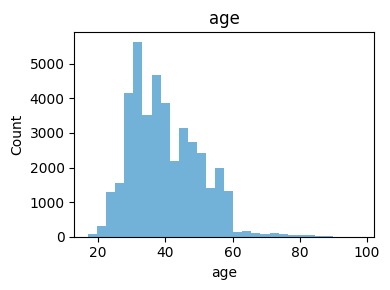

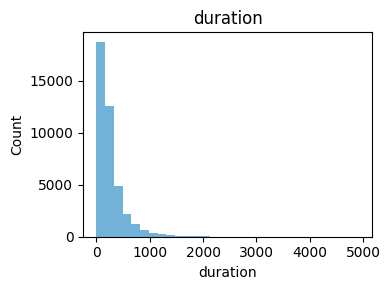

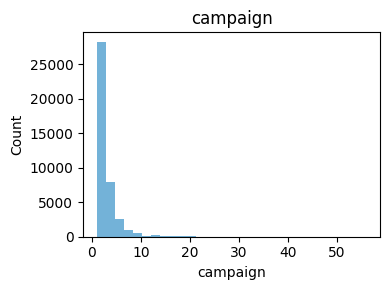

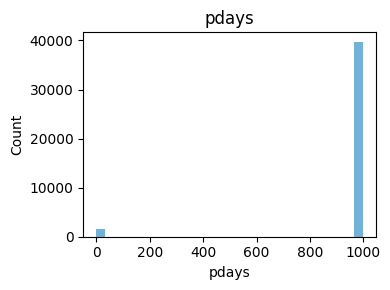

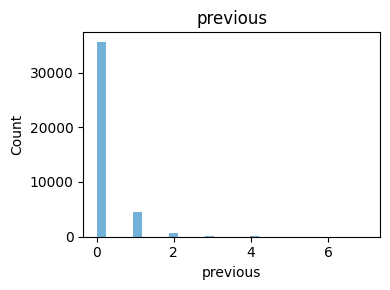

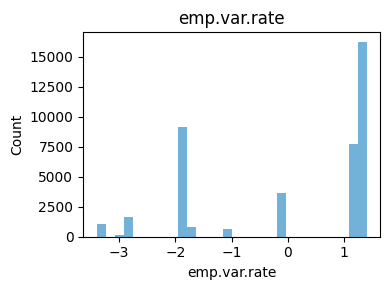

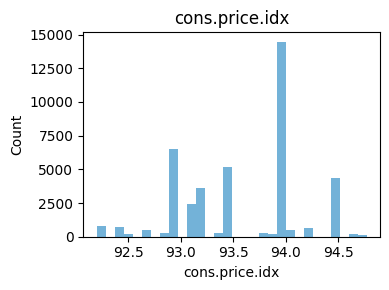

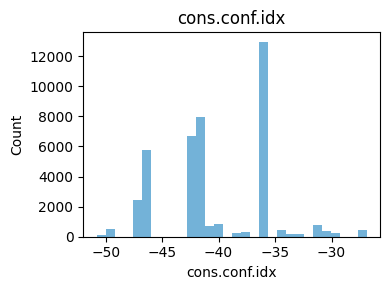

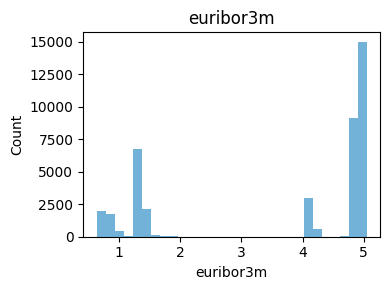

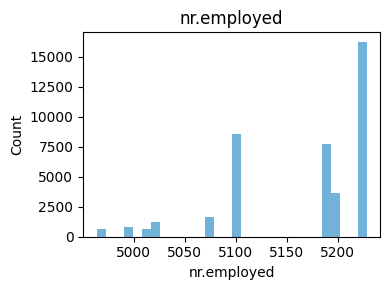

                skew  outlier_%
previous        3.83      13.66
duration        3.26       7.19
campaign        4.76       5.84
pdays          -4.92       3.68
age             0.78       1.14
cons.conf.idx   0.30       1.09
emp.var.rate   -0.72       0.00
cons.price.idx -0.23       0.00
euribor3m      -0.71       0.00
nr.employed    -1.04       0.00


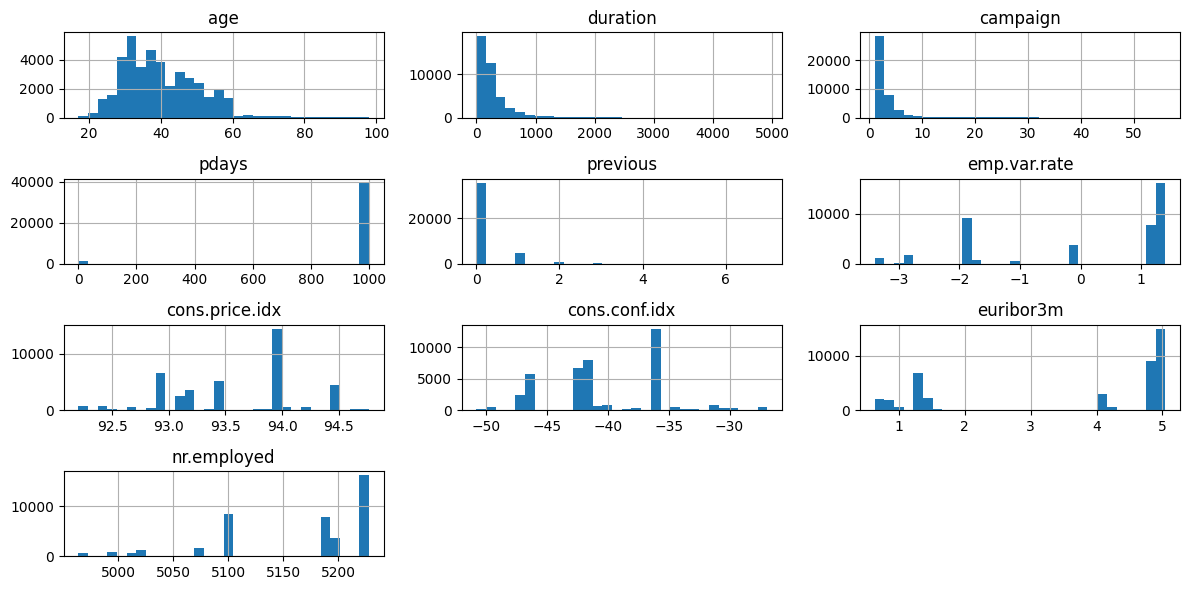

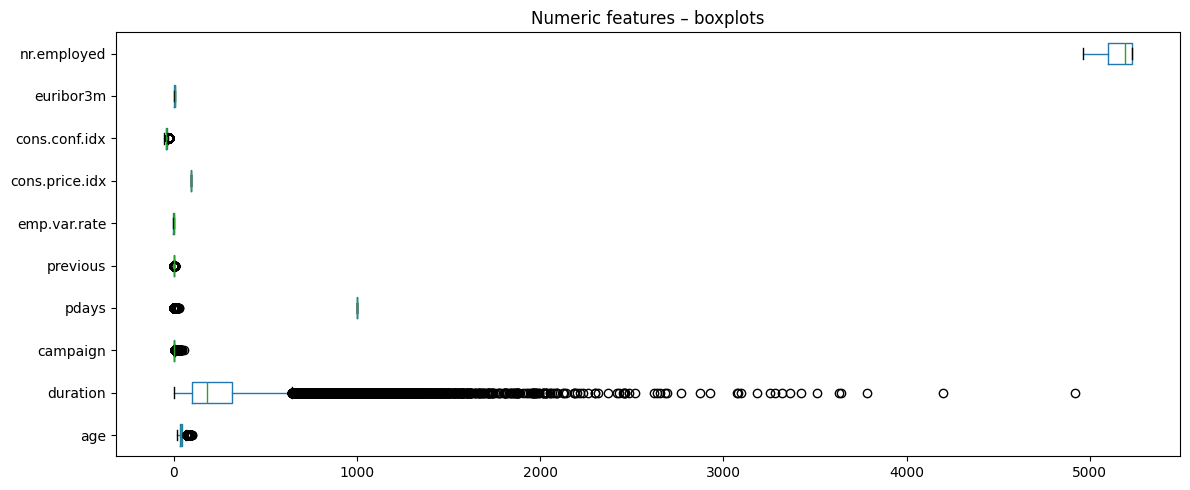

In [9]:
# =========================
# 2) Numeric histograms
# =========================
num_cols = ensure_cols(df, [
    'age','duration','campaign','pdays','previous',
    'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'
])
for col in num_cols:
    fig, ax = plt.subplots(figsize=(4,3))
    df[col].plot(kind='hist', bins=30, color=b_mid, alpha=0.95, ax=ax)
    ax.set_title(col); ax.set_ylabel('Count'); ax.set_xlabel(col)
    plt.tight_layout(); plt.show()

q1 = df[num_cols].quantile(0.25); q3 = df[num_cols].quantile(0.75)
iqr = q3 - q1; lo = q1 - 1.5*iqr; hi = q3 + 1.5*iqr
# =========================
# 2.A.) Creating a summary dataframe and plotting all the numerical variables also in a consolidated
#       histogram view and in a boxplot.
# =========================

summary = pd.DataFrame({
    'skew': df[num_cols].skew(),
    'outlier_%': ((df[num_cols].lt(lo) | df[num_cols].gt(hi)).mean()*100)
}).round(2).sort_values('outlier_%', ascending=False)

print(summary.to_string())

df[num_cols].hist(bins=30, figsize=(12,6))
plt.tight_layout(); plt.show()


df[num_cols].boxplot(vert=False, figsize=(12,5), grid=False)
plt.title('Numeric features – boxplots'); plt.tight_layout(); plt.show()


### Ordering our categorical variable that have an intrisic order:

In [10]:
orderings = {
    'month':       ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    'education':   ['illiterate','basic.4y','basic.6y','basic.9y',
                    'high.school','professional.course','university.degree','unknown'],
    'day_of_week': ['mon','tue','wed','thu','fri'],
}

for c, cats in orderings.items():
    if c in df.columns:
        df[c] = pd.Categorical(df[c], categories=cats, ordered=True)


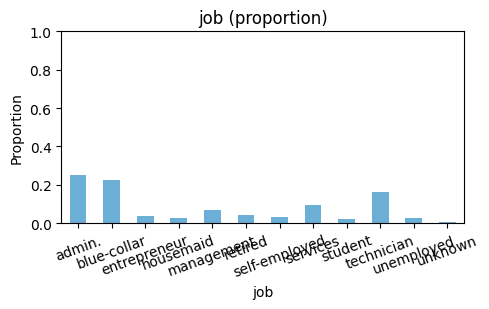

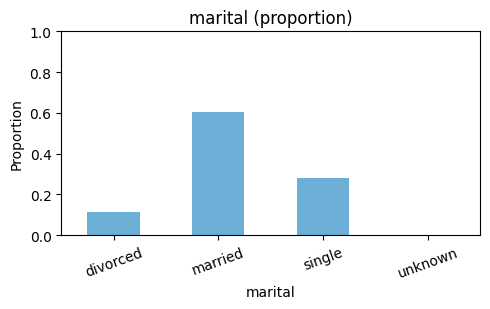

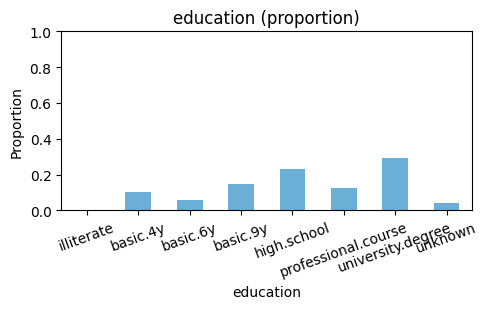

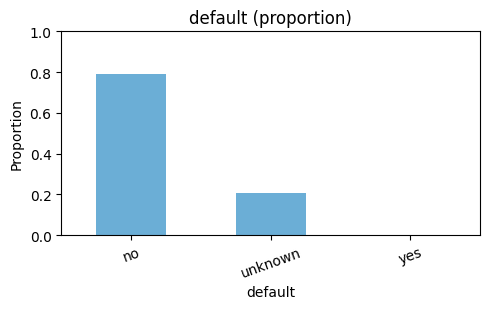

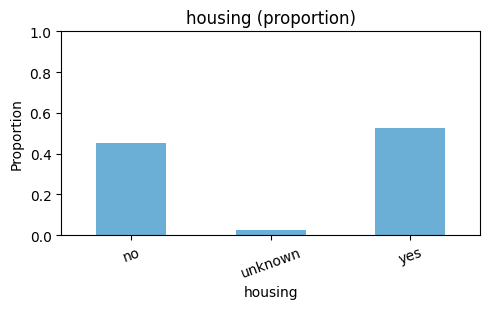

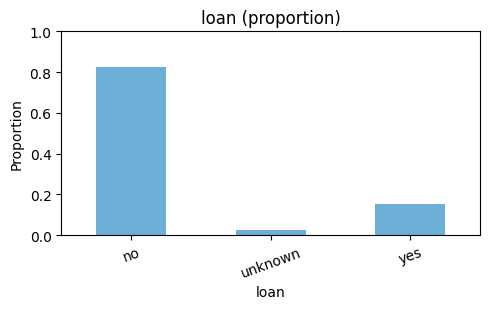

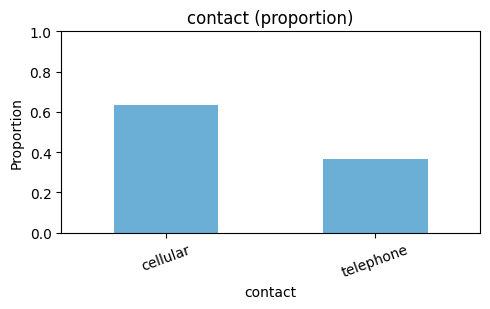

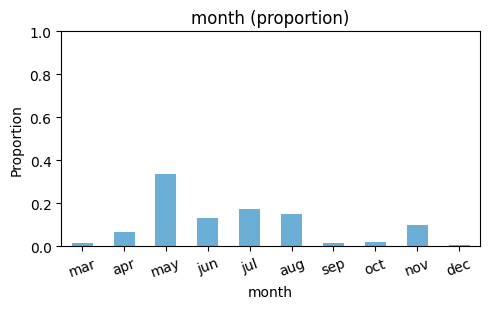

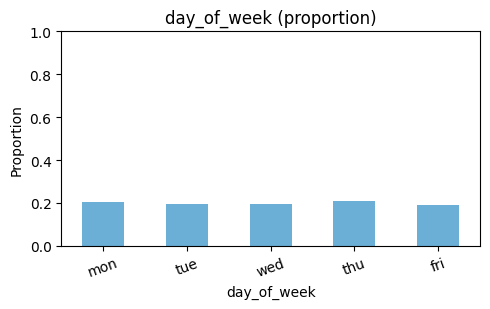

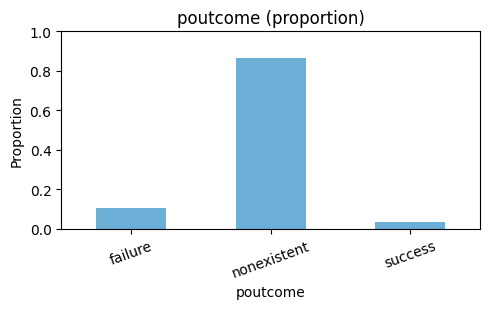

In [11]:
# =========================
# 3) Categorical: normalized bars
# =========================
cat_cols = ensure_cols(df, [
    'job','marital','education','default','housing','loan',
    'contact','month','day_of_week','poutcome'
])
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(5,3.2))
    (df[col].value_counts(normalize=True)
        .sort_index()
        .plot(kind='bar', color=b_mid, ax=ax))
    ax.set_title(f'{col} (proportion)'); ax.set_ylabel('Proportion'); ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout(); plt.show()


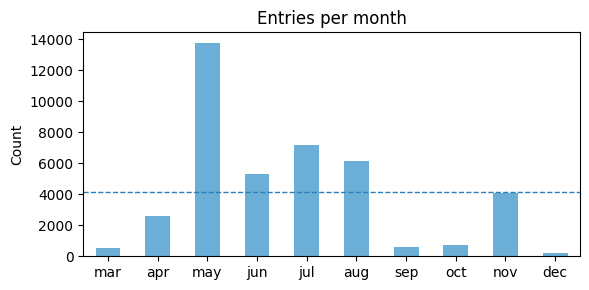


******************************************************************************************************************************************************

mar      546
apr     2632
may    13769
jun     5318
jul     7174
aug     6178
sep      570
oct      718
nov     4101
dec      182


In [12]:
b_dark, b_mid, b_light = "#2C7FB8", "#6BAED6", "#BBD7EA"

cats = df['month'].cat.categories
s = df['month'].value_counts().reindex(cats, fill_value=0)

ax = s.plot(kind='bar', color=b_mid, rot=0, figsize=(6,3), title='Entries per month')
ax.axhline(s.mean(), color=b_dark, linestyle='--', linewidth=1)
ax.set_ylabel('Count'); plt.tight_layout(); plt.show()
print()
print('*'*150)
print()
print(s.astype(int).to_string())

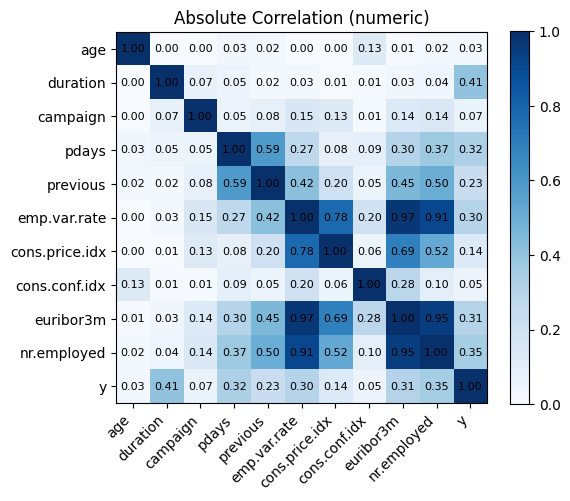

In [13]:
# =========================
# 4) Absolute correlation heatmap (numeric only)
# =========================
num_for_corr = ensure_cols(df, num_cols + ['y'])  # keep only those present
corr = df[num_for_corr].corr().abs()
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(range(len(corr.index)));   ax.set_yticklabels(corr.index)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center', color='black', fontsize=8)
ax.set_title('Absolute Correlation (numeric)'); fig.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()


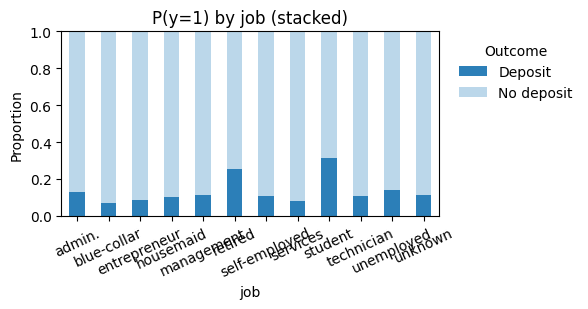

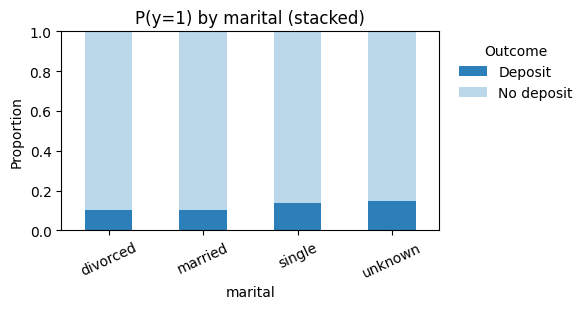

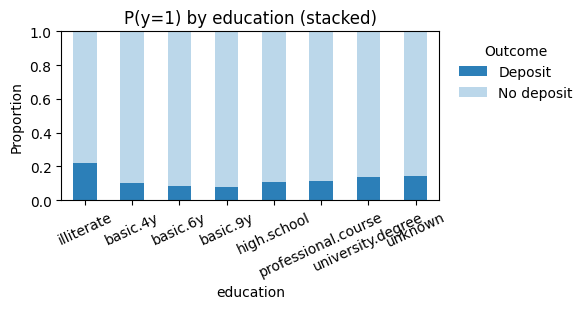

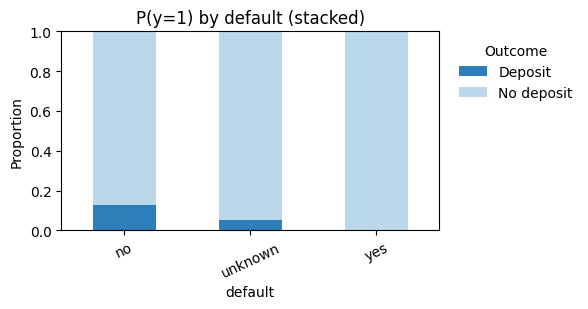

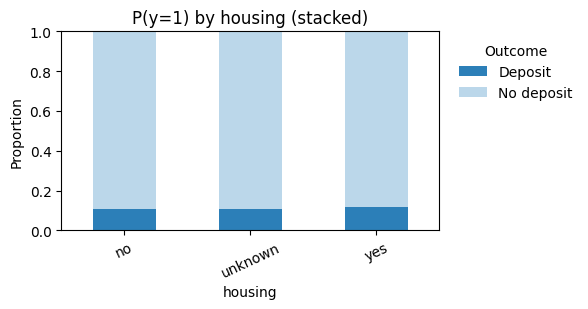

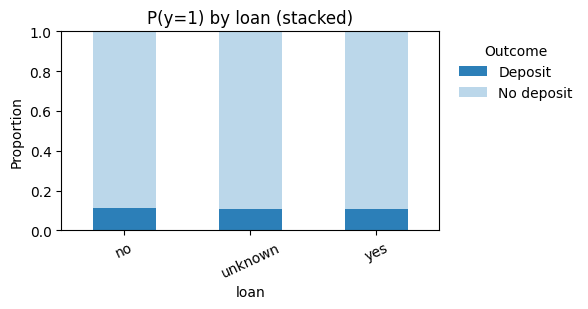

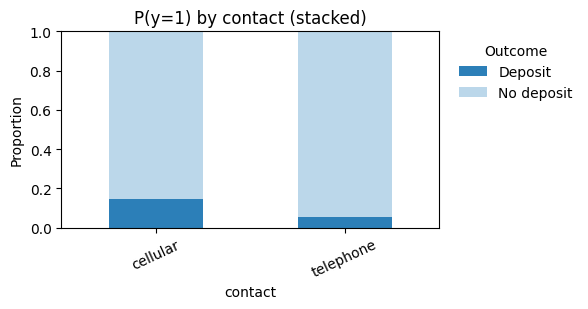

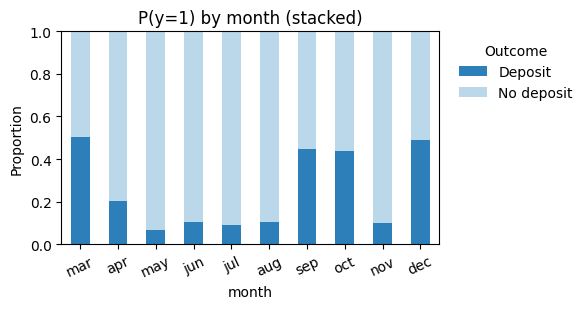

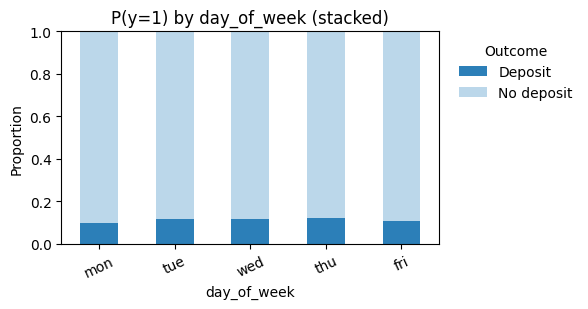

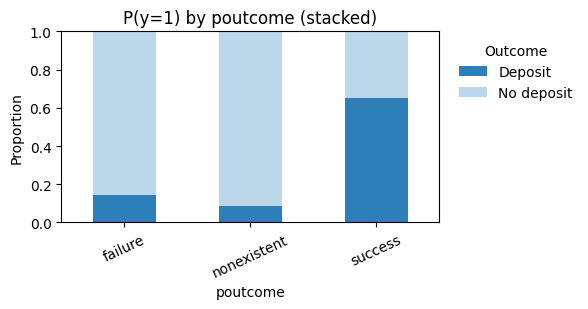

In [14]:
# =========================
# 5) y-rate by categorical (stacked bars)
# =========================
cats_for_rate = cat_cols
for col in cats_for_rate:
    tab = pd.crosstab(df[col], df['y'], normalize='index').reindex(columns=[1,0])
    fig, ax = plt.subplots(figsize=(6,3.2))
    tab.plot(kind='bar', stacked=True, color=[b_dark, b_light], ax=ax, legend=True)
    ax.set_title(f'P(y=1) by {col} (stacked)'); ax.set_ylabel('Proportion'); ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=25)
    ax.legend(['Deposit','No deposit'], loc='upper left', bbox_to_anchor=(1.02, 1.0),
              frameon=False, title='Outcome')
    plt.tight_layout(); plt.show()

### Feature engineering (numerical values):

In [15]:
# --- cross-features & flags ---
df['any_loan'] = ((df['housing'] == 'yes') | (df['loan'] == 'yes')).astype('int8')
df['loan_info_missing'] = ((df['housing'] == 'unknown') | (df['loan'] == 'unknown')).astype('int8')

df['is_student']    = (df['job'] == 'student').astype('int8')
df['is_retired']    = (df['job'] == 'retired').astype('int8')
df['is_unemployed'] = (df['job'] == 'unemployed').astype('int8')

# --- months: include all listed; create a quarter feature ---
month_order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
to_qtr = {
    'mar':'Q1', 'apr':'Q2',
    'may':'Q2','jun':'Q2',
    'jul':'Q3','aug':'Q3','sep':'Q3',
    'oct':'Q4','nov':'Q4','dec':'Q4'
}
df['month_qtr'] = df['month'].map(to_qtr)


In [16]:
# =========================
# PDAYS engineering (from pdays)
# =========================

p = df['pdays']

df['never_contacted']  = (p == 999).astype('int8')
df['days_since_prev_contact_shift_1']     = np.where(p == 999, 0, p + 1).astype('int16')

# Creating two features to indicate whether the lead has ever been contacted and
# also how many times he/she got contacted during this campaing
for c in ['previous','campaign']:
    df[f'{c}_greater_than_0'] = (df[c] > 0).astype('int8')

# Creating a clip on the 99th quantile upper bound.
caps = df[['previous','campaign']].quantile(0.99)
df['previous'] = df['previous'].clip(upper=float(caps['previous']))
df['campaign_clip'] = df['campaign'].clip(upper=float(caps['campaign']))

# Scaling to a log1(P) value to capture better signal over noise.
df['previous_log1p'] = np.log1p(df['previous'])
df['campaign_log1p'] = np.log1p(df['campaign'])

df.drop(columns=['pdays'], inplace=True)

                                 skew  outlier_%
days_since_prev_contact_shift_1  7.32       3.68


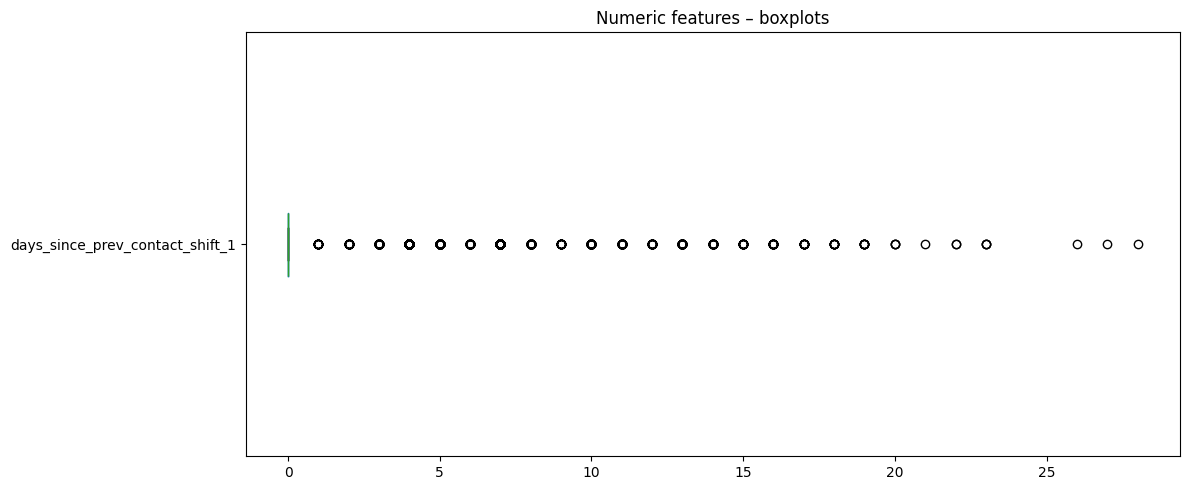

In [17]:
# =========================
# Tiny EDA on days_since_prev_contact_shift_1
# =========================
num_cols = ensure_cols(df, [
    'days_since_prev_contact_shift_1'
])

q1 = df[num_cols].quantile(0.25); q3 = df[num_cols].quantile(0.75)
iqr = q3 - q1; lo = q1 - 1.5*iqr; hi = q3 + 1.5*iqr

summary = pd.DataFrame({
    'skew': df[num_cols].skew(),
    'outlier_%': ((df[num_cols].lt(lo) | df[num_cols].gt(hi)).mean()*100)
}).round(2).sort_values('outlier_%', ascending=False)

print(summary.to_string())

df[num_cols].boxplot(vert=False, figsize=(12,5), grid=False)
plt.title('Numeric features – boxplots'); plt.tight_layout(); plt.show()


### Categorical features `value_counts()` analysis and feature renaming:

In [18]:
# --- 3) % of 'unknown' per feature + blue bar chart wrapped on 2 lines -------
cats = ['job','marital','education','default','housing','loan']
present = [c for c in cats if c in df.columns]

unk_cnt = df[present].eq('unknown').sum()
unk_pct = (df[present].eq('unknown').mean()*100)

order = unk_pct.sort_values(ascending=False).index.tolist()

for c in order:
    vc = df[c].value_counts(dropna=False)
    tot = int(vc.sum())
    parts = [f"{str(k)}={int(v)} ({v*100/tot:.1f}%)" for k, v in vc.items()]
    print(f"{c:<12} (n={tot}) → " + " | ".join(parts))

default      (n=41188) → no=32588 (79.1%) | unknown=8597 (20.9%) | yes=3 (0.0%)
education    (n=41188) → university.degree=12168 (29.5%) | high.school=9515 (23.1%) | basic.9y=6045 (14.7%) | professional.course=5243 (12.7%) | basic.4y=4176 (10.1%) | basic.6y=2292 (5.6%) | unknown=1731 (4.2%) | illiterate=18 (0.0%)
housing      (n=41188) → yes=21576 (52.4%) | no=18622 (45.2%) | unknown=990 (2.4%)
loan         (n=41188) → no=33950 (82.4%) | yes=6248 (15.2%) | unknown=990 (2.4%)
job          (n=41188) → admin.=10422 (25.3%) | blue-collar=9254 (22.5%) | technician=6743 (16.4%) | services=3969 (9.6%) | management=2924 (7.1%) | retired=1720 (4.2%) | entrepreneur=1456 (3.5%) | self-employed=1421 (3.5%) | housemaid=1060 (2.6%) | unemployed=1014 (2.5%) | student=875 (2.1%) | unknown=330 (0.8%)
marital      (n=41188) → married=24928 (60.5%) | single=11568 (28.1%) | divorced=4612 (11.2%) | unknown=80 (0.2%)


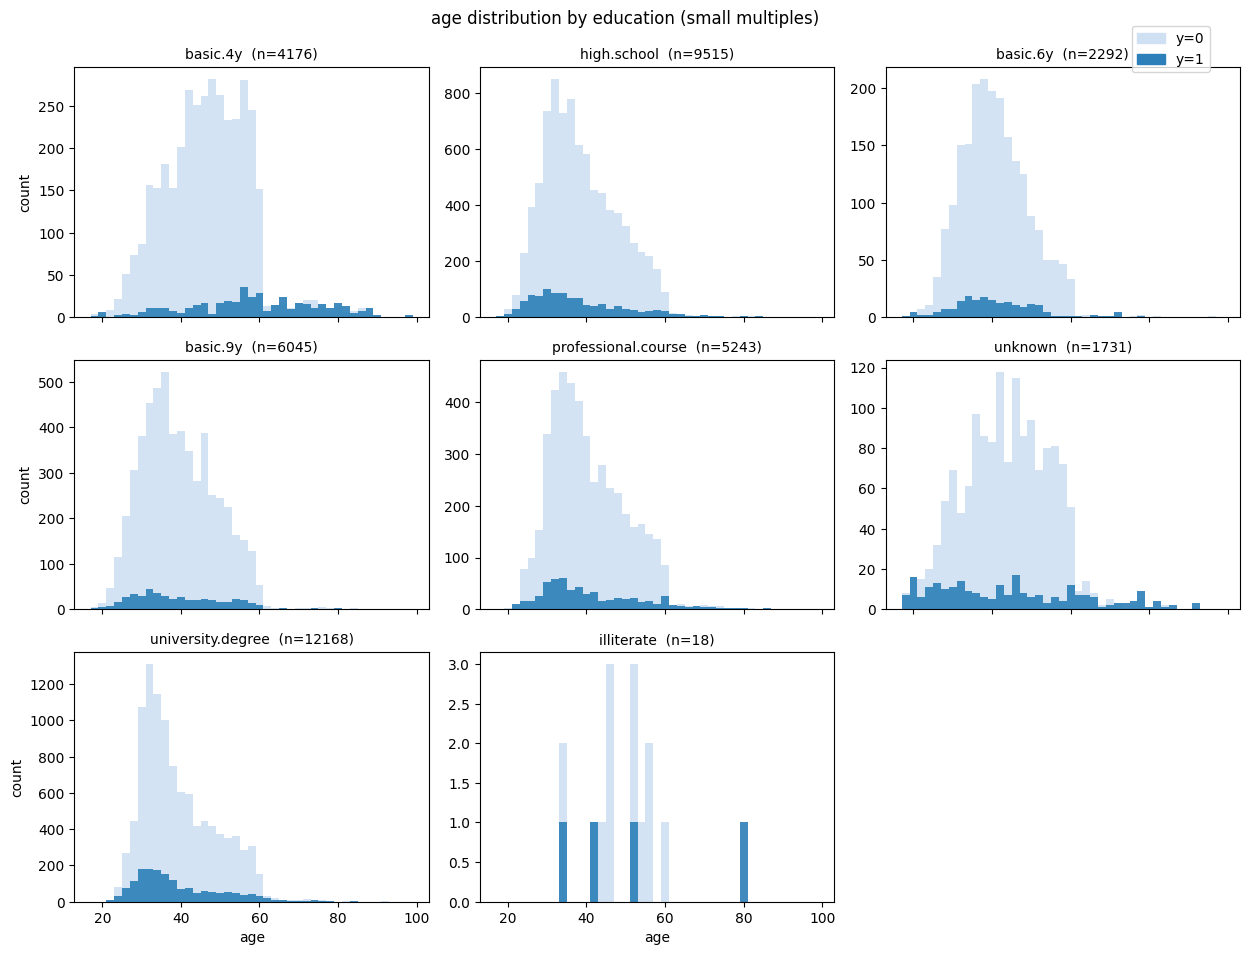

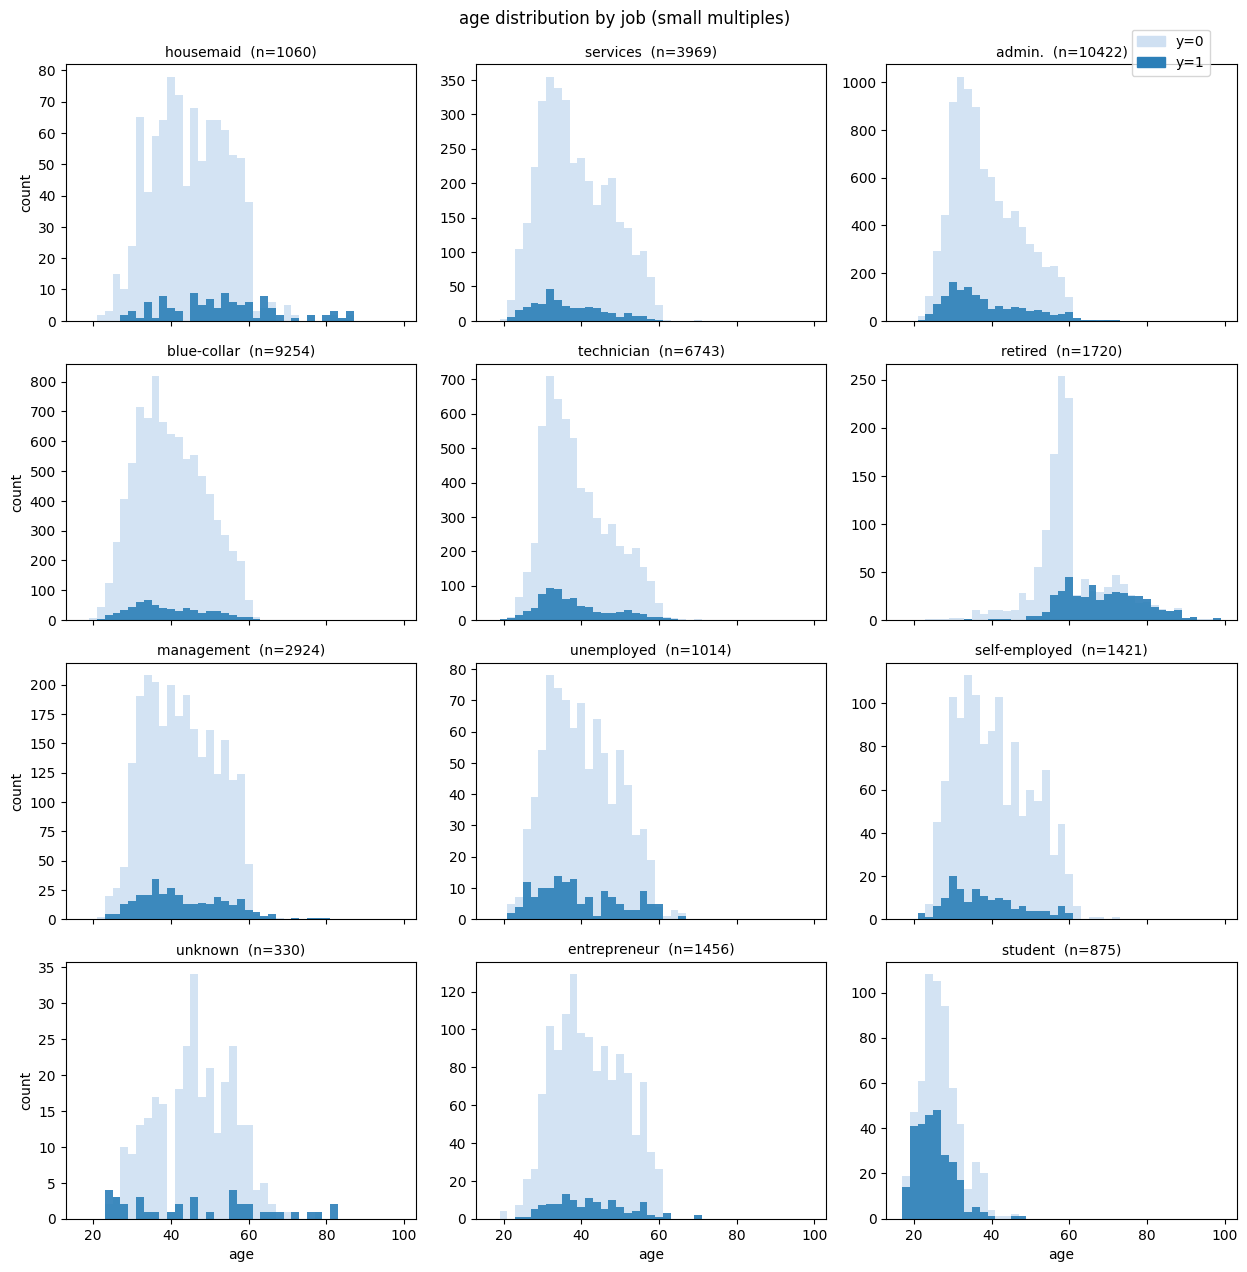

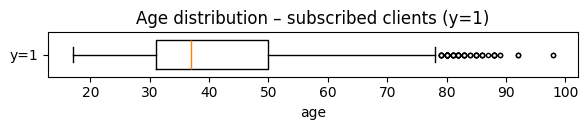

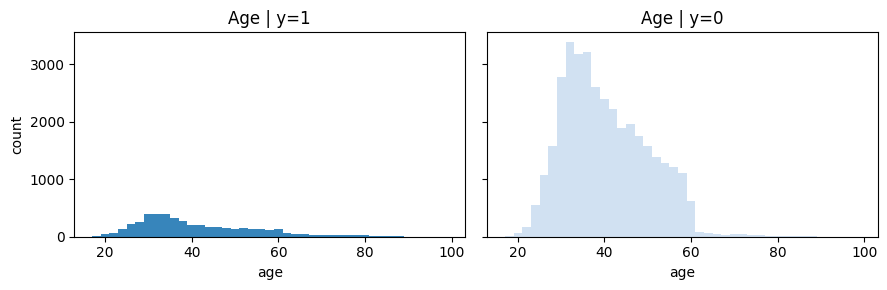

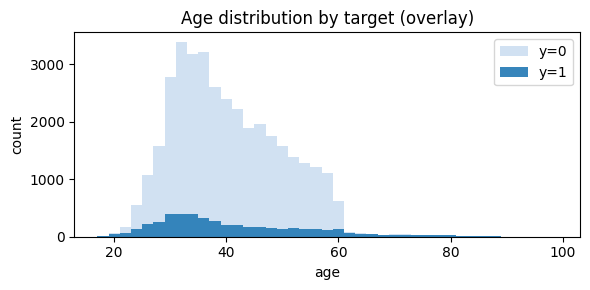

In [19]:
c0, c1 = "#cfe0f2", "#2c7fb8"           # y=0 (light), y=1 (dark)
bins = np.arange(df['age'].min(), df['age'].max() + 2, 2)

# ---------- A) Small multiples: age by a categorical column ----------
def age_small_multiples(df, cat, ncols=3):
    cats = [c for c in df[cat].dropna().unique()]
    nrows = int(np.ceil(len(cats) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.2, nrows*3.2), sharex=True)
    axes = np.array(axes).reshape(-1)   # flatten even if 1xN

    for i, c in enumerate(cats):
        sub = df[df[cat] == c]
        ax = axes[i]
        ax.hist(sub.loc[sub['y']==0, 'age'], bins=bins, color=c0, alpha=0.9)
        ax.hist(sub.loc[sub['y']==1, 'age'], bins=bins, color=c1, alpha=0.9)
        ax.set_title(f"{c}  (n={len(sub)})", fontsize=10)
        if i // ncols == nrows - 1: ax.set_xlabel("age")
        if i % ncols == 0:          ax.set_ylabel("count")

    # remove any empty axes
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])

    fig.suptitle(f"age distribution by {cat} (small multiples)", y=0.99, fontsize=12)
    # Global legend (top-right)
    from matplotlib.patches import Patch
    handles = [Patch(color=c0, label="y=0"), Patch(color=c1, label="y=1")]
    fig.legend(handles=handles, loc="upper right", bbox_to_anchor=(0.97, 0.98))
    plt.tight_layout()
    plt.show()

# Use for education and job
age_small_multiples(df, 'education', ncols=3)
age_small_multiples(df, 'job',       ncols=3)

# ---------- B) Horizontal boxplot for y=1 ----------
fig, ax = plt.subplots(figsize=(6,1.4))
ax.boxplot(df.loc[df['y']==1, 'age'], vert=False, widths=0.65,
           flierprops=dict(marker='o', markersize=3, markerfacecolor='white', markeredgecolor='black'))
ax.set_yticks([1]); ax.set_yticklabels(['y=1'])
ax.set_xlabel("age"); ax.set_title("Age distribution – subscribed clients (y=1)")
plt.tight_layout(); plt.show()

# ---------- C) Side-by-side histograms: Age | y=1 vs Age | y=0 ----------
fig, axes = plt.subplots(1, 2, figsize=(9,3), sharey=True)
axes[0].hist(df.loc[df['y']==1, 'age'], bins=bins, color=c1, alpha=0.95)
axes[0].set_title("Age | y=1"); axes[0].set_xlabel("age"); axes[0].set_ylabel("count")
axes[1].hist(df.loc[df['y']==0, 'age'], bins=bins, color=c0, alpha=0.95)
axes[1].set_title("Age | y=0"); axes[1].set_xlabel("age")
plt.tight_layout(); plt.show()

# ---------- D) Overlay histogram: Age by target ----------
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(df.loc[df['y']==0, 'age'], bins=bins, color=c0, alpha=0.95, label="y=0")
ax.hist(df.loc[df['y']==1, 'age'], bins=bins, color=c1, alpha=0.95, label="y=1")
ax.set_xlabel("age"); ax.set_ylabel("count"); ax.set_title("Age distribution by target (overlay)")
ax.legend()
plt.tight_layout(); plt.show()

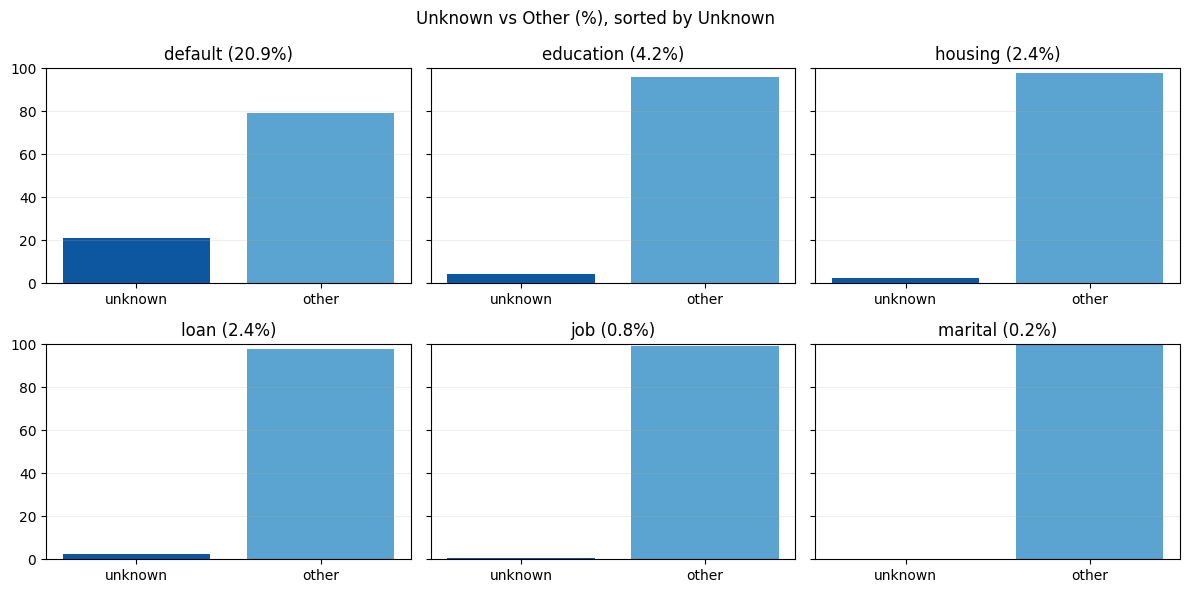

In [20]:
ncols = math.ceil(len(order)/2) or 1
fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 6), sharey=True); axes = axes.ravel()
for i, c in enumerate(order):
    p = unk_pct[c]
    axes[i].bar(['unknown','other'], [p, 100-p], color=[plt.cm.Blues(0.85), plt.cm.Blues(0.55)])
    axes[i].set_title(f"{c} ({p:.1f}%)"); axes[i].set_ylim(0,100); axes[i].grid(axis='y', alpha=0.2)
for j in range(i+1, len(axes)): fig.delaxes(axes[j])
fig.suptitle('Unknown vs Other (%), sorted by Unknown'); plt.tight_layout(); plt.show()

### From this code, we can observe that in most of our categorical features we have the presence of the category 'uknown', therefore, we must dive deeper.


---


### Over the next parts, we will analyse feature by feature. Let's start with Default:


In [21]:
df['default'] = df['default'].replace({'yes':'unknown'})
df = df.join(pd.get_dummies(df['default'], prefix='default', drop_first=False, dtype='int8')) \
       .drop(columns='default')

### Now let's move over to *Education*:

In [22]:
edu_order = {
    'illiterate':0,'basic.4y':1,'basic.6y':2,'basic.9y':3,
    'high.school':4,'professional.course':5,'university.degree':6,
    'unknown':3  # put unknown at mid-rank
}
df['education_unknown'] = (df['education'] == 'unknown').astype('int8')
df['education_ord'] = df['education'].map(edu_order).astype('int8')
df.drop(columns=['education'], inplace=True)

### Housing:
This variable showcase `yes=21576 (52.4%) | no=18622 (45.2%) | unknown=990 (24%) `, therefore, we can handle the Unknown values by expanding them with the `pd.get_dummies` method.

In [23]:
dummies = pd.get_dummies(df['housing'], prefix='housing', drop_first=False, dtype='int8')
df.drop(columns=['housing'], inplace=True)
df = df.join(dummies)

### Job Feature:

In [24]:
# First, we fix a typo in one of the job values (i.e. 'admin.' to -> 'admin')

df['job'] = df['job'].replace({'admin.':'admin'})
print('job         →', df['job'].unique())

job         → ['housemaid' 'services' 'admin' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


In [25]:
df = df.join(pd.get_dummies(df.pop('job'), prefix='job', drop_first=False, dtype='int8'))

### Loan & Marital:

In [26]:
df = df.join(pd.get_dummies(df.pop('loan'), prefix='loan', drop_first=False, dtype='int8'))

df = df.join(pd.get_dummies(df.pop('marital'), prefix='marital', drop_first=False, dtype='int8'))

### Now, let's move over to the last four categorical features and analyse how to handle them:

In [27]:
for c in ['contact','month','day_of_week', 'poutcome']:
    vc = df[c].value_counts()
    tot = int(vc.sum())
    print(f"\n{c} (n={tot})")
    print((vc.astype(str) + " (" + (vc*100/tot).round(1).astype(str) + "%)").to_string())


contact (n=41188)
contact
cellular     26144 (63.5%)
telephone    15044 (36.5%)

month (n=41188)
month
may    13769 (33.4%)
jul     7174 (17.4%)
aug     6178 (15.0%)
jun     5318 (12.9%)
nov     4101 (10.0%)
apr      2632 (6.4%)
oct       718 (1.7%)
sep       570 (1.4%)
mar       546 (1.3%)
dec       182 (0.4%)

day_of_week (n=41188)
day_of_week
thu    8623 (20.9%)
mon    8514 (20.7%)
wed    8134 (19.7%)
tue    8090 (19.6%)
fri    7827 (19.0%)

poutcome (n=41188)
poutcome
nonexistent    35563 (86.3%)
failure         4252 (10.3%)
success          1373 (3.3%)


### Let's perform OneHot Econding for such features `('contact','day_of_week', 'poutcome', 'month_qtr')`:
### For the latter one, we will first create a new feature named 'prev_contacted' indicating whether that person has already been contacted or not. Then, create the OHE representation.

In [28]:
df = df.join(pd.get_dummies(df.pop('contact'),     prefix='contact', dtype='int8'))
df = df.join(pd.get_dummies(df.pop('day_of_week'), prefix='dow',     dtype='int8'))
df = df.join(pd.get_dummies(df.pop('month_qtr'), prefix='quarter_ID',dtype='int8'))
df['prev_contacted'] = (df['poutcome'] != 'nonexistent').astype('int8')
df = df.join(pd.get_dummies(df.pop('poutcome'), prefix='previous_outcome',dtype='int8'))

### Now that we have gained a better understanding of our categorical features, we can move on towards numerical:

In [29]:
print('Numerical values by column:')

display(df.describe())


Numerical values by column:


,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,any_loan,loan_info_missing,is_student,is_retired,is_unemployed,never_contacted,days_since_prev_contact_shift_1,previous_greater_than_0,campaign_greater_than_0,campaign_clip,previous_log1p,campaign_log1p,default_no,default_unknown,education_unknown,education_ord,housing_no,housing_unknown,housing_yes,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,loan_no,loan_unknown,loan_yes,marital_divorced,marital_married,marital_single,marital_unknown,contact_cellular,contact_telephone,dow_mon,dow_tue,dow_wed,dow_thu,dow_fri,quarter_ID_Q1,quarter_ID_Q2,quarter_ID_Q3,quarter_ID_Q4,prev_contacted,previous_outcome_failure,previous_outcome_nonexistent,previous_outcome_success
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.0,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,0.162402,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,0.585923,0.024036,0.021244,0.041760,0.024619,0.963217,0.258012,0.136569,1.0,2.500024,0.105137,1.118991,0.791201,0.208799,0.042027,4.112144,0.452122,0.024036,0.523842,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,0.024619,0.008012,0.824269,0.024036,0.151695,0.111974,0.605225,0.280859,0.001942,0.634748,0.365252,0.206711,0.196416,0.197485,0.209357,0.190031,0.013256,0.527314,0.338011,0.121419,0.136569,0.103234,0.863431,0.033335
std,10.42125,259.279249,2.770014,0.433241,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,0.492568,0.153163,0.144199,0.200042,0.154962,0.188230,1.510327,0.343396,0.0,2.301191,0.270796,0.491402,0.406455,0.406455,0.200653,1.620913,0.497708,0.153163,0.499437,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,0.154962,0.089152,0.380596,0.153163,0.358729,0.315339,0.488808,0.449424,0.044029,0.481507,0.481507,0.404951,0.397292,0.398106,0.406855,0.392330,0.114372,0.499259,0.473038,0.326617,0.343396,0.304268,0.343396,0.179512
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.693147,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50

In [30]:
df = df.rename(columns={
    'emp.var.rate': 'employment_variation_rate',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'euribor3m': 'euribor_3_month_rate',
    'nr.employed': 'number_of_employees',
    'previous': 'n_previous_contacts'
})

### Before proceeding, we need to remove the `Duration` column as advised also in the dataset description. We'll do this for a dual reason: when forecasting `y`, we don't know in advance how much the call lasted and, if we were to keep it in the training set, then, we would be shaping on noise rather than signal.

In [31]:
df = df.drop(columns=['duration'])

### Train-Validate-Test Split:

Since our data is following a temporal series (march:dec) we cannot split with the classic sklearn train_test split due to a concrete data leak risk. Therefore we are going to conduce a small EDA to assess whether a 6-2-2 scheme following the temporal distribution would make more sense.

In [32]:
train_m = ['mar','apr','may','jun','jul','aug']
val_m   = ['sep','oct']
test_m  = ['nov','dec']
m_train = df['month'].isin(train_m)
m_val   = df['month'].isin(val_m)
m_test  = df['month'].isin(test_m)

df = df.join(pd.get_dummies(df.pop('month'), prefix='month', dtype='int8'))

X = df.drop(columns=['y']); y = df['y']
X_train, y_train = X[m_train], y[m_train]
X_val,   y_val   = X[m_val],   y[m_val]
X_test,  y_test  = X[m_test],  y[m_test]

print(" Train months:", train_m, '\n', "Validation months:", val_m, "\n","Testing momths:", test_m)

 Train months: ['mar', 'apr', 'may', 'jun', 'jul', 'aug'] 
 Validation months: ['sep', 'oct'] 
 Testing momths: ['nov', 'dec']


### Now we can perform OHE on the `month` column and finally drop it:

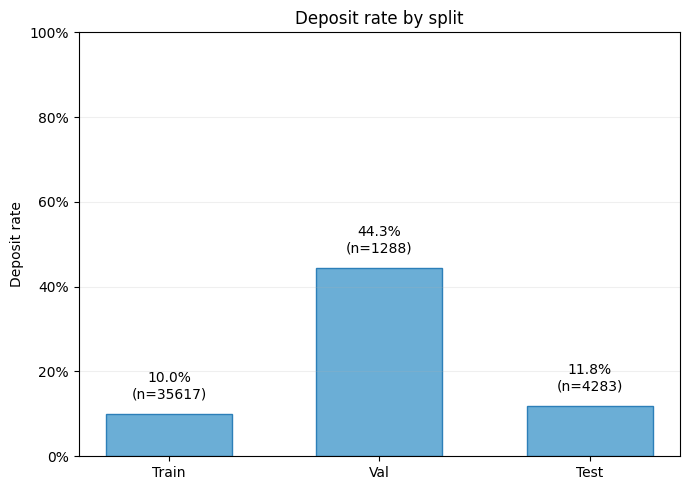

In [33]:
labels = ['Train','Val','Test']
vals   = [y_train.mean(), y_val.mean(), y_test.mean()]
ns     = [len(y_train),   len(y_val),   len(y_test)]

fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(len(labels))
ax.bar(x, vals, width=0.6, color=b_mid, edgecolor=b_dark)

ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.set_ylabel('Deposit rate')
ax.set_title('Deposit rate by split')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', alpha=0.2)

for i, (v, n) in enumerate(zip(vals, ns)):
    ax.text(x[i], min(v+0.03, 0.98), f"{v:.1%}\n(n={n})",
            ha='center', va='bottom', fontsize=10)

plt.tight_layout(); plt.show()

In [34]:
# --- 3) preprocessing (no categoricals → passthrough) ---
num_cols = X_train.columns.tolist()
preprocess = 'passthrough'

## Training our decision tree classifier with Gini impurity:

In [35]:
dt_base = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_base.fit(X_train, y_train)

print(f"Baseline DT | train acc: {dt_base.score(X_train,y_train):.3f} "
      f"| val acc: {dt_base.score(X_val,y_val):.3f} "
      f"| test acc: {dt_base.score(X_test,y_test):.3f}")

Baseline DT | train acc: 0.994 | val acc: 0.609 | test acc: 0.713


## Tuning max_depth, min_samples_split, ccp_alpha:

In [ ]:
dt_pipe = Pipeline([('clf', DecisionTreeClassifier(criterion='gini', random_state=42))])

param_grid = {
    'clf__max_depth': [None, 4, 6, 8, 10, 12],
    'clf__min_samples_split': [2, 20, 100],
    'clf__ccp_alpha': [0.0, 1e-4, 1e-3, 1e-2],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    dt_pipe, param_grid=param_grid, cv=cv,
    scoring='accuracy', n_jobs=-1, refit=True
)
grid.fit(X_train, y_train)

print("DT (accuracy CV) best params:", grid.best_params_)
print("DT (accuracy CV) best mean CV acc:", f"{grid.best_score_:.3f}")

best_dt, best_params_ap, best_ap = None, None, -1.0
cell_ap = defaultdict(lambda: -1.0)
depths_set, splits_set = set(), set()

for params in grid.cv_results_['params']:
    plain_params = {k.replace('clf__', ''): v for k, v in params.items()}
    dt_tmp = DecisionTreeClassifier(criterion='gini', random_state=42, **plain_params)
    dt_tmp.fit(X_train, y_train)
    val_proba = dt_tmp.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_proba)
    if ap > best_ap:
        best_ap, best_params_ap, best_dt = ap, params, dt_tmp
    d = plain_params['max_depth']
    s = plain_params['min_samples_split']
    depths_set.add(d); splits_set.add(s)
    cell_ap[(d, s)] = max(cell_ap[(d, s)], ap)

print("DT (Val AUCPR-selected) params:", best_params_ap, "| Val AUCPR:", f"{best_ap:.3f}")

print(f"DT | train acc: {best_dt.score(X_train,y_train):.3f} "
      f"| val acc: {best_dt.score(X_val,y_val):.3f} "
      f"| test acc: {best_dt.score(X_test,y_test):.3f}")

## Overfitting vs underfitting: train vs val acc by depth

In [ ]:
depths = [1, 2, 3, 4, 6, 8, 10, 12, None]
labels = [str(d) for d in depths]
x = np.arange(len(depths))

tr, va = [], []
for d in depths:
    clf = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    tr.append(clf.score(X_train, y_train))
    va.append(clf.score(X_val,   y_val))

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x, tr, marker='o', label='Train')
ax.plot(x, va, marker='o', label='Validation')

ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_xlabel('max_depth'); ax.set_ylabel('Accuracy'); ax.set_ylim(0, 1)
ax.set_title('Decision Tree: Under/Overfitting')
ax.grid(alpha=0.2); ax.legend()
plt.tight_layout(); plt.show()

## “Learning curve” over depth:

In [ ]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42)
train_sizes, train_scores, val_scores = learning_curve(
    clf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
ax.plot(train_sizes, val_scores.mean(axis=1),   marker='o', label='Validation')
ax.set_xlabel('Training examples'); ax.set_ylabel('Accuracy'); ax.set_ylim(0,1)
ax.set_title('Learning Curve (DT, Gini)'); ax.grid(alpha=0.2); ax.legend()
plt.tight_layout(); plt.show()


In [ ]:
depths = sorted(depths_set, key=lambda x: (x is None, x if x is not None else float('inf')))
splits = sorted(splits_set)

M = np.full((len(depths), len(splits)), np.nan)
for i, d in enumerate(depths):
    for j, s in enumerate(splits):
        M[i, j] = cell_ap[(d, s)]

fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(M, cmap='Blues', vmin=np.nanmin(M), vmax=np.nanmax(M))
ax.set_xticks(range(len(splits))); ax.set_xticklabels(splits)
ax.set_yticks(range(len(depths))); ax.set_yticklabels([str(d) for d in depths])
ax.set_xlabel('min_samples_split'); ax.set_ylabel('max_depth')
ax.set_title('Decision Tree: Val AUCPR by (depth, min_samples_split)')
fig.colorbar(im, ax=ax, label='Val AUCPR')
plt.tight_layout(); plt.show()

## Boosting methods: Random Forest

In [ ]:
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions={
        'n_estimators': [300, 600],
        'max_depth': [None, 8, 12],
        'min_samples_split': [2, 20],
        'min_samples_leaf': [1, 5],
        'max_features': ['sqrt', 0.5],
    },
    n_iter=12,
    scoring='average_precision',  # tune by AUCPR
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    refit=True
)
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_

print("RF best params     :", rf_search.best_params_)
print("RF best CV AUCPR   :", f"{rf_search.best_score_:.3f}")
print(f"RF baseline | train acc: {rf.score(X_train,y_train):.3f} "
      f"| val acc: {rf.score(X_val,y_val):.3f} "
      f"| test acc: {rf.score(X_test,y_test):.3f}")

In [ ]:
def fit_gb(lr, n_est, depth=3, subsample=1.0):
    gb = GradientBoostingClassifier(
        learning_rate=lr,
        n_estimators=n_est,
        max_depth=depth,
        subsample=subsample,
        random_state=42
    ).fit(X_train, y_train)
    ap_val = average_precision_score(y_val, gb.predict_proba(X_val)[:, 1])
    return gb, ap_val

grid_lr = [(0.01, 800), (0.1, 300), (0.3, 150)]

cands = []
for lr, ne in grid_lr:
    for depth in [2, 3, 4]:
        for subs in [1.0, 0.8]:
            gb_tmp, ap = fit_gb(lr, ne, depth=depth, subsample=subs)
            cands.append((ap, lr, ne, depth, subs, gb_tmp))

ap, lr, ne, depth, subs, gb_best2 = max(cands, key=lambda t: t[0])
print(f"GB study → best Val AUCPR={ap:.3f} at lr={lr}, n_estimators={ne}, max_depth={depth}, subsample={subs}")

gb_best = gb_best2

try:
    gb_table = (pd.DataFrame([(a, l, n, d, s) for a, l, n, d, s, _ in cands],
                             columns=['Val_AUCPR','learning_rate','n_estimators','max_depth','subsample'])
                  .sort_values('Val_AUCPR', ascending=False))
    print("\nTop 5 GradientBoosting configs by Val AUCPR:\n",
          gb_table.head(5).to_string(index=False, float_format=lambda x: f"{x:.3f}"))
except Exception:
    pass


## Training vs. Validation loss across boosting iterations:

In [ ]:
def staged_logloss(clf, X_tr, y_tr, X_va, y_va):
    tr_ll, va_ll = [], []
    for proba_tr, proba_va in zip(clf.staged_predict_proba(X_tr), clf.staged_predict_proba(X_va)):
        tr_ll.append(log_loss(y_tr, proba_tr))
        va_ll.append(log_loss(y_va, proba_va))
    return np.array(tr_ll), np.array(va_ll)

tr_ll, va_ll = staged_logloss(gb_best, X_train, y_train, X_val, y_val)

iters = np.arange(1, len(tr_ll) + 1)
best = int(np.argmin(va_ll)) + 1

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(iters, tr_ll, linewidth=2, label='Train logloss')
ax.plot(iters, va_ll, linewidth=2, label='Val logloss')
ax.axvline(best, ls='--', lw=1, color='gray', label=f'best={best}')
ax.set_xlabel('Boosting Iterations'); ax.set_ylabel('Log Loss')
ax.set_title('Gradient Boosting: Training vs Validation Loss')
ax.grid(alpha=0.2); ax.legend()
plt.tight_layout(); plt.show()



## XGBoost:

In [ ]:
pos = int(y_train.sum()); neg = int((1 - y_train).sum())
ratio = neg / max(pos, 1)

def fit_xgb(lr, depth, spw):
    m = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss',
        learning_rate=lr, max_depth=depth, n_estimators=2000,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=spw,
        random_state=42, n_jobs=-1, tree_method='hist'
    )
    m.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val,y_val)], verbose=False)
    er = m.evals_result()
    br = int(np.argmin(er['validation_1']['logloss']))
    # AUCPR on Val at best round
    val_proba = m.predict_proba(X_val, iteration_range=(0, br+1))[:, 1]
    ap = average_precision_score(y_val, val_proba)
    return m, br, ap

cands = []
for lr in [0.01, 0.1, 0.3]:
    for depth in [3, 6, 9]:
        for spw in [1.0, np.sqrt(ratio), ratio]:
            m, br, ap = fit_xgb(lr, depth, spw)
            cands.append((ap, lr, depth, spw, br, m))

ap, lr, depth, spw, br, xgb_best = max(cands, key=lambda t: t[0])
print(f"XGB study → best Val AUCPR={ap:.3f} at lr={lr}, depth={depth}, spw={spw:.2f}, best_round={br}")

xgb_model   = xgb_best
best_round  = br
er = xgb_model.evals_result()

In [ ]:
def proba_at_round(model, X, r):
    return model.predict_proba(X, iteration_range=(0, r+1))[:, 1]

def acc_at_round(model, X, y, r):
    p = proba_at_round(model, X, r)
    return ((p >= 0.5).astype(int) == y).mean()


print(f"XGB | train acc: {acc_at_round(xgb_model, X_train, y_train, best_round):.3f} "
      f"| val acc: {acc_at_round(xgb_model, X_val, y_val, best_round):.3f} "
      f"| test acc: {acc_at_round(xgb_model, X_test, y_test, best_round):.3f}")
print()

plt.figure(figsize=(10, 4))
plt.plot(er['validation_0']['logloss'], label='Train logloss')
plt.plot(er['validation_1']['logloss'], label='Val logloss')
plt.axvline(best_round, ls='--', lw=1, color='gray', label='best round')
plt.xlabel('Boosting Rounds'); plt.ylabel('Log Loss')
plt.title('XGBoost: Training vs Validation Loss'); plt.legend(); plt.tight_layout(); plt.show()

importances = xgb_model.get_booster().get_score(importance_type='gain')
imp = pd.Series(importances).sort_values(ascending=False)
top = imp.head(20); labels = list(top.index[::-1]); vals = top.values[::-1]

fig, ax = plt.subplots(figsize=(10, 4))
y = np.arange(len(labels))
ax.barh(y, vals, color=b_mid, edgecolor=b_dark)
ax.set_yticks(y); ax.set_yticklabels(labels)
ax.set_xlabel('Gain'); ax.set_title('XGBoost – Top 20 Feature Importances (gain)')
ax.grid(axis='x', alpha=0.2)
plt.tight_layout(); plt.show()


### Evaluation and Visualization:

In [ ]:
def _plot_confmat(ax, y_true, y_pred, classes=('0','1'), title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    im = ax.imshow(cm, cmap='Blues')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]}", ha='center', va='center', color='black')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_title(title)
    ax.grid(False)

def _plot_pr(ax, y_true, y_proba, title='PR Curve'):
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    ax.plot(rec, prec, lw=2)
    ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
    ax.set_title(f'{title} (AP={ap:.3f})')
    ax.grid(alpha=0.2)

def eval_report(name, model, X_tr, y_tr, X_va, y_va, X_te, y_te, proba_fn=None):
    """Return a flat Series of metrics and draw (CM | PR) for TEST on one line."""
    # probs
    if proba_fn is None:
        get_proba = (lambda m, X: m.predict_proba(X)[:,1]) if hasattr(model, "predict_proba") \
                    else (lambda m, X: (getattr(m, "decision_function")(X) if hasattr(model,"decision_function") else m.predict(X)).astype(float))
    else:
        get_proba = lambda m, X: proba_fn(m, X)

    # train
    p_tr = get_proba(model, X_tr); ytr_pred = (p_tr >= 0.5).astype(int)
    # val
    p_va = get_proba(model, X_va); yva_pred = (p_va >= 0.5).astype(int)
    # test
    p_te = get_proba(model, X_te); yte_pred = (p_te >= 0.5).astype(int)

    row = {
        'Model': name,
        'Train_Accuracy':  accuracy_score(y_tr, ytr_pred),
        'Val_Accuracy':    accuracy_score(y_va, yva_pred),
        'Test_Accuracy':   accuracy_score(y_te, yte_pred),
        'Test_Precision':  precision_score(y_te, yte_pred, zero_division=0),
        'Test_Recall':     recall_score(y_te, yte_pred, zero_division=0),
        'Test_F1':         f1_score(y_te, yte_pred, zero_division=0),
        'Test_AUCPR':      average_precision_score(y_te, p_te),
    }

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    _plot_confmat(axes[0], y_te, yte_pred, classes=('0','1'), title=f'{name} – Confusion Matrix (Test)')
    _plot_pr(axes[1], y_te, p_te, title=f'{name} – PR Curve (Test)')
    plt.tight_layout(); plt.show()

    print(f"\n{name} – Test classification report:\n", classification_report(y_te, yte_pred, digits=3))

    return pd.Series(row)

rows = []
rows.append(eval_report('DecisionTree(best)', best_dt, X_train, y_train, X_val, y_val, X_test, y_test))
if 'rf' in locals():
    rows.append(eval_report('RandomForest', rf, X_train, y_train, X_val, y_val, X_test, y_test))
rows.append(eval_report('GradientBoosting(best)', gb_best, X_train, y_train, X_val, y_val, X_test, y_test))
rows.append(eval_report('XGBoost(ES)', xgb_model, X_train, y_train, X_val, y_val, X_test, y_test,
                        proba_fn=lambda m, X: proba_at_round(m, X, best_round)))

summary = pd.DataFrame(rows).set_index('Model')
summary = summary.sort_values('Test_AUCPR', ascending=False)

print("\nSummary (sorted by Test_AUCPR):\n")
print(summary.to_string(float_format=lambda x: f"{x:.3f}"))


metrics_to_plot = ['Test_Accuracy','Test_F1','Test_AUCPR']
colors = [b_light, b_mid, b_dark]

labels = summary.index.tolist()
x = np.arange(len(labels))
w = 0.22

fig, ax = plt.subplots(figsize=(10, 4))
for i, (m, c) in enumerate(zip(metrics_to_plot, colors)):
    ax.bar(x + (i-1)*w, summary[m].values, width=w, label=m.replace('Test_',''), color=c, edgecolor='#2C7FB8')

ax.set_xticks(x); ax.set_xticklabels(labels, rotation=15)
ax.set_ylim(0, 1); ax.set_ylabel('Score'); ax.set_title('Model Comparison – Test Metrics')
ax.grid(axis='y', alpha=0.2); ax.legend(title='Metric')
plt.tight_layout(); plt.show()